# Geneformer for cell class prediction and data projection

This notebook provides examples to utilize the fine-tuned Geneformer model with user data. For more information on the model please refer to the Census Model page (TODO insert link).

**Contents**

1. Requirements.
   2. System requirements.
   3. Example data and fine-tuned model.
1. Preparing data and model.
1. Using the Geneformer fine-tuned model for cell class inference
1. Using the Geneformer fine-tuned model for data projection

⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Requirements

### System requirements

To run this notebook the following are required:

- Unix system.
- A system with one or more GPUs is highly recommended.
- [AWS command-line interface](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html).
- [Geneformer Python package](https://huggingface.co/ctheodoris/Geneformer) and its dependencies.
- CELLxGENE Census package

### Example data and fine-tuned model

Throughout the notebook the 10X PBMC 3K dataset will be used, you can download it via the following shell commands.


In [1]:
!mkdir -p data
!wget -nv -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

2023-12-04 13:37:50 URL:https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [7621991/7621991] -> "data/pbmc3k_filtered_gene_bc_matrices.tar.gz" [1]


And we will need the Geneformer fine-tuned model trained on Census data.

In [2]:
!aws s3 sync s3://mlin-census-scratch/geneformer/test/20231024_012902_finetune_geneformer/ ./fine_tuned_geneformer  --no-progress --only-show-errors

Finally all the required package are loaded 

In [3]:
from transformers import BertForSequenceClassification
from transformers import Trainer
from geneformer import DataCollatorForCellClassification
from geneformer import TranscriptomeTokenizer
from geneformer import EmbExtractor
from cellxgene_census.experimental import get_embedding
from cellxgene_census.experimental.ml.huggingface import GeneformerTokenizer
import datasets
import json
import os
import scanpy as sc
import numpy as np
import cellxgene_census
import tiledbsoma

/home/ubuntu/venv_census/lib/python3.11/site-packages/loompy/bus_file.py:67: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/ubuntu/venv_census/lib/python3.11/site-packages/loompy/bus_file.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/ubuntu/venv_census/lib/python3.11/site-packages/loompy/bus_file.py:101: NumbaDeprecationWarning: The '

## Preparaing data and model

### Data

Let's load the test data. In preparation to use with Geneformer the following: 
- Sets the index as the ENSEMBL ID and stores it in the `obs` column `"ensembl_id"`
- Adds read counts to the `obs` column `"n_counts"`
- Adds and ID column to be used for joining later in the  `obs` column `"joinid"`

Then we write the resulting H5AD file to disk.

In [4]:
adata = sc.read_10x_mtx('data/filtered_gene_bc_matrices/hg19/', var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] =  adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))

h5ad_dir = "./data/h5ad/"

if not os.path.exists(h5ad_dir):
    os.makedirs(h5ad_dir)
    
adata.write(h5ad_dir + "pbmcs.h5ad")

Now we can tokenize the test data using Geneformer's tokenizer, while keeping track of `"joinid"` for future joining.

In [6]:
token_dir = "data/tokenized_data/"

if not os.path.exists(token_dir):
    os.makedirs(token_dir)

tokenizer = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid"})
tokenizer.tokenize_data(
    data_directory = h5ad_dir, 
    output_directory = token_dir, 
    output_prefix = "pbmc", 
    file_format = "h5ad",
)

Tokenizing data/h5ad/pbmcs.h5ad
data/h5ad/pbmcs.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/home/ubuntu/venv_census/lib/python3.11/site-packages/geneformer/tokenizer.py:194: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id"][coding_miRNA_loc]
/home/ubuntu/venv_census/lib/python3.11/site-packages/geneformer/tokenizer.py:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id"][coding_miRNA_loc]
/home/ubuntu/venv_census/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(

Creating dataset.


Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2700 [00:00<?, ? examples/s]

### Model data

Then let's fetch the mapping dictionary between Geneformer IDs and the associated cell class labels. This information is stored along the fine-tuned model.

In [7]:
model_dir = "./fine_tuned_geneformer/model/1250_per_cell_type_10epochs_bf16/"
label_mapping_dict_file = os.path.join(model_dir, "label_to_cell_subclass.json")

with open(label_mapping_dict_file, "r") as fp:
    label_mapping_dict = json.load(fp)

This dictionary contains all the possible cell labels available for the model, and the predictions on the section below will use these labels.

In [8]:
label_mapping_dict

{'0': 'B cell',
 '1': 'CD4-positive, alpha-beta T cell',
 '2': 'CD8-positive, alpha-beta T cell',
 '3': 'CNS neuron (sensu Vertebrata)',
 '4': 'GABAergic neuron',
 '5': 'T cell',
 '6': 'abnormal cell',
 '7': 'adventitial cell',
 '8': 'animal cell',
 '9': 'bone cell',
 '10': 'cardiocyte',
 '11': 'cell of skeletal muscle',
 '12': 'ciliated cell',
 '13': 'columnar/cuboidal epithelial cell',
 '14': 'connective tissue cell',
 '15': 'contractile cell',
 '16': 'defensive cell',
 '17': 'dendritic cell',
 '18': 'duct epithelial cell',
 '19': 'ecto-epithelial cell',
 '20': 'ectodermal cell',
 '21': 'endo-epithelial cell',
 '22': 'endocrine cell',
 '23': 'endothelial cell',
 '24': 'epithelial cell',
 '25': 'epithelial cell of lung',
 '26': 'epithelial cell of pancreas',
 '27': 'epithelial cell of urethra',
 '28': 'eukaryotic cell',
 '29': 'exocrine cell',
 '30': 'fat cell',
 '31': 'fibroblast',
 '32': 'germ cell',
 '33': 'glandular epithelial cell',
 '34': 'glial cell',
 '35': 'glutamatergic neur

## Using the Geneformer fine-tuned model for cell class inference

### Loading tokenized data

Let's load the tokenized test data.

In [9]:
dataset = datasets.load_from_disk(token_dir + "pbmc.dataset")
dataset

Dataset({
    features: ['input_ids', 'joinid', 'length'],
    num_rows: 2700
})

We add a dummy cell metadata column `"label"` needed for Geneformer to make predictions.

In [10]:
dataset
dataset = dataset.add_column("label", [0] * len(dataset))

### Performing inference of cell class

Now we can load the model and run the inference workflow.

In [11]:
# reload pretrained model
model = BertForSequenceClassification.from_pretrained(model_dir)
# create the trainer
trainer = Trainer(model=model, data_collator=DataCollatorForCellClassification())
# use trainer
predictions = trainer.predict(dataset)

/home/ubuntu/venv_census/lib/python3.11/site-packages/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


And finally we select the most likely cell class based on the probability vector from the predictions of each cell in our test data.

In [12]:
predicted_label_ids = np.argmax(predictions.predictions, axis=1)
predicted_labels = [label_mapping_dict[str(i)] for i in predicted_label_ids]

### Inspecting inference results

Then we add the data back to our loaded AnnData test dataset.

In [13]:
adata.obs["predicted_cell_subclass"] = predicted_labels

And it's ready for inspecting the predictions. Let's visualize the predictions on the UMAP space, the following is a basic processing workflow to derive a UMAP representation, of the data.

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/ubuntu/venv_census/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ubuntu/venv_census/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fu

Let's also add the original cell type annotations as obtained in [Scapy's annotation tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) of the same data. 

In [15]:
sc.tl.leiden(adata)
original_cell_types = [
    "CD4-positive, alpha-beta T cell (1)",
    "CD4-positive, alpha-beta T cell (2)",
    "CD14-positive, monocyte",
    "B cell (1)",
    "CD8-positive, alpha-beta T cell",
    "FCGR3A-positive, monocyte",
    "natural killer cell",
    "dendritic cell",
    "megakaryocyte",
    "B cell (2)",
]
adata.rename_categories('leiden', original_cell_types)

These are the original annotations.

/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


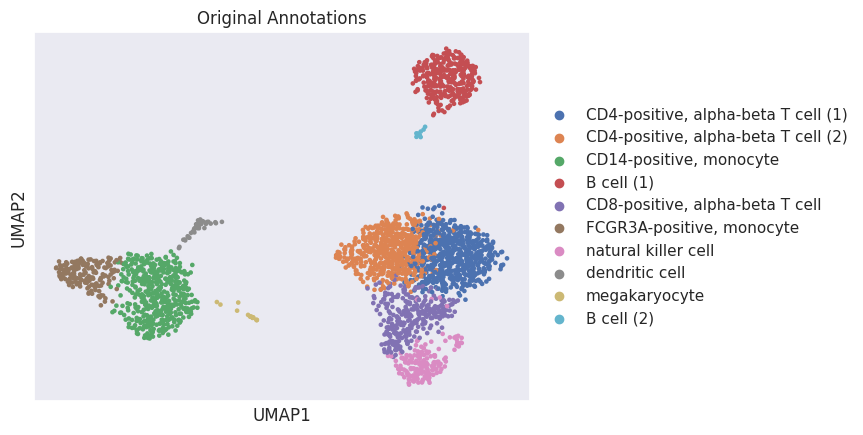

In [21]:
sc.pl.umap(adata, color = "leiden", title = "Original Annotations")

And these are the predicted annotations.

/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


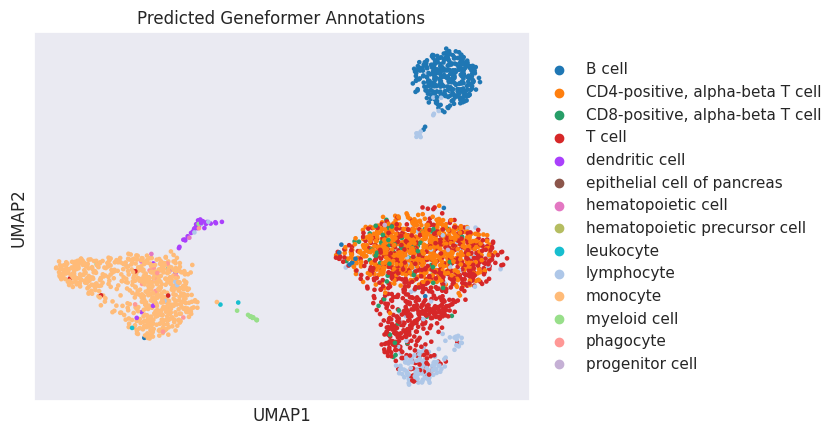

In [22]:
sc.pl.umap(adata, color = "predicted_cell_subclass", title = "Predicted Geneformer Annotations")

## Using the Geneformer fine-tuned model for data projection

### Generating Geneformer embeddings for 10X PBMC 3K data

To project new data, for example the 10X PBMC 3K data, into the Census embedding space from Geneformer's fine-tune model, we can use `EmbExtractor` from the [Geneformer](https://huggingface.co/ctheodoris/Geneformer) package as follows.

We first need to get the number of categories (cell subclasses) present in the model.

In [24]:
n_classes = len(label_mapping_dict)

Then we can run the `EmbExtractor`, which randomize the cells during the process and thus we keep track of `"joinid"`.

In [25]:
output_dir = "data/geneformer_embeddings"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

embex = EmbExtractor(
    model_type="CellClassifier",
    num_classes=n_classes,
    max_ncells = None,
    emb_label = ["joinid"],
    emb_layer=-1,
    forward_batch_size=30,
    nproc=8
)

embs = embex.extract_embs(
    model_directory = model_dir,
    input_data_file = token_dir + "pbmc.dataset",
    output_directory = output_dir,
    output_prefix = "emb"
)

  0%|          | 0/90 [00:00<?, ?it/s]

Then we simply re-order the embeddings based on `"joinid"` and then merge them to the original AnnData

In [27]:
embs = embs.sort_values("joinid")
adata.obsm["X_geneformer"] = embs.drop(columns="joinid").to_numpy()

Let's take a look at these Geneformer embeddings in a UMAP representation

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="X_geneformer")
sc.tl.umap(adata)

/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ubuntu/venv_census/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


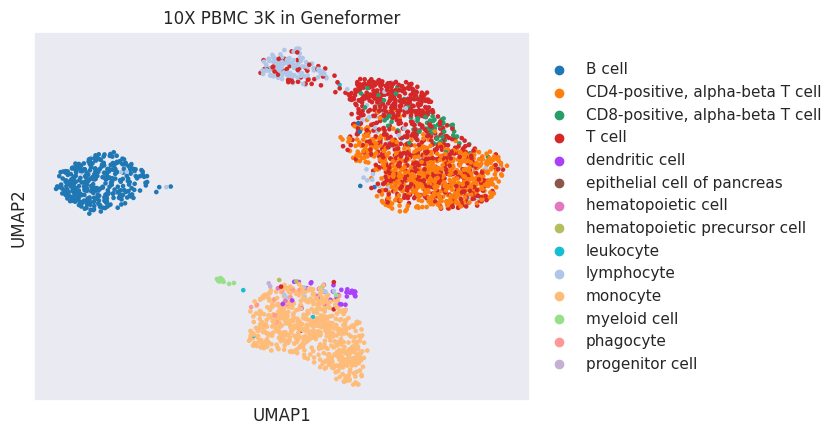

In [29]:
sc.pl.umap(adata, color = "predicted_cell_subclass", title = "10X PBMC 3K in Geneformer")

### Joining Geneformer embeddings from 10X PBMC 3K data with other Census datasets

There are multiple datasets in Census from PBMCs, and all human Census data has pre-calculated Geneformer embeddings, so now we can join the embeddings we generated above from the 10X PBMC 3K dataset with Census data.

Let's grab a few PBMC datasets from Census.

In [31]:
config = {
    "vfs.s3.region": "us-west-2",
    "py.init_buffer_bytes": 1 * 1024**3,
    "soma.init_buffer_bytes": 1 * 1024**3,
}

ctx = tiledbsoma.options.SOMATileDBContext()
ctx = ctx.replace(tiledb_config=config)
census = cellxgene_census.open_soma(uri="s3://bruce-tmp/2023-10-23/soma", context=ctx)

In [32]:
# "Individual Single-Cell RNA-seq PBMC Data from Guo et al."
dataset_ids=["fa8605cf-f27e-44af-ac2a-476bee4410d3", "3c75a463-6a87-4132-83a8-c3002624394d"]

adata_census = cellxgene_census.get_anndata(
    census=census,
    measurement_name="RNA",
    organism="Homo sapiens",
    obs_value_filter=f"dataset_id in {dataset_ids}",
    obsm_layer = "geneformer",
)

To simplify let's select the genes that are also present in the 10X PBMC 3K dataset.

In [ ]:
adata_census.var_names=adata_census.var["feature_id"]
shared_genes = list(set(adata.var_names) & set(adata_census.var_names))
adata_census = adata_census[:,shared_genes]

And subset to only 

In [ ]:
adata_census.obsm["X_geneformer"] = get_embedding('2023-10-23', "s3://bruce-tmp/emb-build-2023-11-30/CxG-czi-1/", adata_census.obs["soma_joinid"].to_numpy(), context=ctx)


In [ ]:
sc.pp.neighbors(adata_census, n_neighbors=10, n_pcs=40, use_rep="X_geneformer")


In [ ]:
sc.tl.umap(adata_census)

In [ ]:
sc.pl.umap(adata_census, color = "cell_type", alpha = 0.6)

In [ ]:
sc.pl.umap(adata_census, color = "dataset_id", alpha = 0.6)

In [ ]:
adata_joined = sc.concat([adata, adata_census[[str(i) for i in embs["soma_joinid"]],:]], join="outer", label='batch')
#adata_joined = sc.concat([adata, adata_census], join="outer", label='batch')


In [ ]:
sc.pp.neighbors(adata_joined, n_neighbors=10, n_pcs=40, use_rep="X_geneformer")

In [ ]:
sc.tl.umap(adata_joined)

In [ ]:
sc.pl.umap(adata_joined, color = "cell_type", alpha = 0.6)

In [ ]:
sc.pl.umap(adata_joined, color = "dataset_id", alpha = 0.6)

In [ ]:
sc.pl.umap(adata_joined, color = "predicted_cell_subclass", alpha = 0.6)

In [ ]:
adata_joined.obs["batch"]

In [ ]:
with GeneformerTokenizer(
    census["census_data"]["homo_sapiens"],
    # set obs_query to define some subset of Census cells:
    obs_query=tiledbsoma.AxisQuery(coords = (adata_census.obs["soma_joinid"].to_numpy(),) ),
    obs_column_names=(
        "soma_joinid",
        "cell_type",
    ),
) as tokenizer:
    dataset = tokenizer.build()

In [ ]:
dataset.save_to_disk("census.dataset")

In [ ]:
n_classes = len(label_mapping_dict)
output_dir = "geneformer_embeddings_census"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

embex = EmbExtractor(model_type="CellClassifier",
                     num_classes=n_classes,
                     max_ncells = 5000,
                     emb_label = ["soma_joinid"],
                     emb_layer=-1,
                     forward_batch_size=30,
                     nproc=94)

# extracts embedding from input data
# example dataset: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
embs = embex.extract_embs(model_dir,
                          "census.dataset",
                          output_dir,
                          "emb")

In [ ]:
embs = embs.sort_values("soma_joinid")

In [ ]:
embs

In [ ]:
adata_census.obs_names = [str(i) for i in adata_census.obs["soma_joinid"]]

In [ ]:
adata_census_sub = adata_census[[str(i) for i in embs["soma_joinid"]],:]
adata_census_sub.obsm["X_geneformer"] = embs.drop(columns="soma_joinid").to_numpy()

In [ ]:
adata_joined = sc.concat([adata, adata_census_sub], join="outer", label='batch')

In [ ]:
sc.pp.neighbors(adata_joined, n_neighbors=10, n_pcs=40, use_rep="X_geneformer")

In [ ]:
sc.tl.umap(adata_joined)

In [ ]:
sc.pl.umap(adata_joined, color = "dataset_id", alpha = 0.6)

In [ ]:
sc.pl.umap(adata_joined, color = "predicted_cell_subclass", alpha = 0.6)

# Scratch

In [ ]:
adata.X

In [ ]:
adata